In [14]:
import os
import sys
import time

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import sklearn
import xgboost

In [15]:
# Basic
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
# Functions
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv

# Tools
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV

# Transformers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [5]:
def load_test_images(limit: int = -1):
    folder = './data/test1'
    images_names = os.listdir(folder)
    
    images_names = images_names[:limit]
    
    X = []
    
    for file_name in images_names:
        img = cv2.imread(folder + '/' + file_name)
            
        X.append(img)
        
    return X

def load_train_images(limit: int = -1):
    folder = './data/train'
    images_names = os.listdir(folder)
    
    cats = list(filter(lambda x: x.startswith('cat'), images_names))
    dogs = list(filter(lambda x: x.startswith('dog'), images_names))
    
    if (0 < limit) and (limit < len(images_names)):
        cats = cats[:int(limit/2)]
        dogs = dogs[:(limit - int(limit/2))]
    
    X = []
    y = []
    
    for label, names in enumerate([cats, dogs]):
        for file_name in names:
            img = cv2.imread(folder + '/' + file_name)
            
            X.append(img)
            y.append(label)
        
    return (X, y)

## Load the data

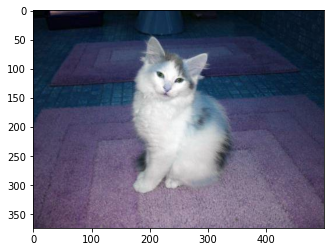

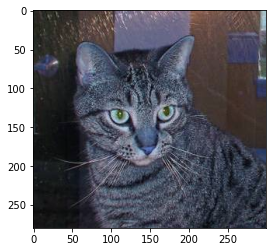

In [6]:
original_test = load_test_images(2)
X_train, y_train = load_train_images(4)

plt.imshow(original_test[1])
plt.show()

plt.imshow(X_train[1])
plt.show()

Has 25000 images


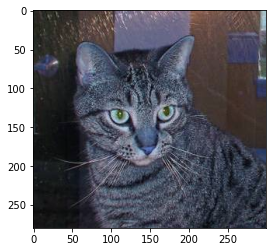

(374, 500, 3)

In [7]:
X_origin, y_origin = load_train_images()

print('Has ' + str(len(y_origin)) + ' images')
plt.imshow(X_origin[1])
plt.show()

X_origin[0].shape

In [8]:
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_origin, y_origin, test_size=0.3, random_state=42)

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X_final_train, y_final_train, test_size=0.9, random_state=11)
X_train, X_test, y_train, y_test = train_test_split(X_final_train, y_final_train, test_size=0.1, random_state=11)

In [10]:
print("Size of final tain and test:", len(X_final_train), ":", len(X_final_test))
print("Size of tain and test:", len(X_train), ":", len(X_test))

Size of final tain and test: 17500 : 7500
Size of tain and test: 15750 : 1750


# Create and train the Model
## Targets
* resize
* grayscale
* image as vector

In [14]:
X_train[0].shape

(83, 160, 3)

X    0.0
Y    0.0
dtype: float64

In [135]:
# First building
class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y):
        return self
    
    def transform(self, x, y = None):
        
        new_x = x.copy()
        
        for i, sample in enumerate(new_x):
            resized = cv2.resize(sample, (100, 100), interpolation = cv2.INTER_AREA)
            
            as_vaector = resized.reshape((resized.shape[0] * resized.shape[1] * resized.shape[2]))
            
            new_x[i] = as_vaector
        
        X_df = pd.DataFrame(new_x)
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

1.0

In [185]:
# try grayscale

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y):
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        
        new_x = x.copy()
                
        for i, sample in enumerate(new_x):
            resized_img = cv2.resize(sample, (100, 100), interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        X_df = pd.DataFrame(new_x)
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

transform 543
transform 233


1.0

In [ ]:
# resize_dim

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        mid_x = 0
        mid_y = 0

        for sample in X_train:
            mid_x += sample.shape[0]
            mid_y += sample.shape[1]

        mid_x = int(mid_x/len(X_train))
        mid_y = int(mid_y/len(X_train))
        
        self.resize_dim = (mid_x, mid_y)
        
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
                
        for i, sample in enumerate(new_x):
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        X_df = pd.DataFrame(new_x)
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

transform 543
resize dim (362, 410)


In [16]:
# resize_dim baised median

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print(i)
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

transform 1575
resize dim (374, 446)
0


KeyboardInterrupt: 

In [24]:
# resize_dim = (28, 28)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        self.resize_dim = (28,28)
        
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print(i)
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

transform 1575
resize dim (28, 28)
0
157
314
471
628
785
942
1099
1256
1413
1570
complit transform
transform 175
resize dim (28, 28)
0
17
34
51
68
85
102
119
136
153
170
complit transform


0.6457142857142857

In [27]:
# make it prety

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        self.resize_dim = (28,28)
        
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

transform 1575
resize dim (28, 28)
...........
complit transform
transform 175
resize dim (28, 28)
...........
complit transform


0.6457142857142857

In [ ]:
# self.resize_dim = (28,28 * int(height_median / width_median))

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (28,28 * int(height_median / width_median))
        
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

In [16]:
# resize_dim = (width_median, height_median)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
                
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.628

transform 15750
resize dim (374, 447)
.0.7945389747619629
0.7925069332122803
0.7881810665130615
0.7891337871551514
0.7897534370422363
0.7929995059967041
0.7836980819702148
0.7920002937316895
0.7960009574890137
0.7949984073638916
0.7870008945465088
0.7950003147125244
0.7829992771148682
0.7840266227722168
0.7889747619628906
0.7939989566802979
0.7850255966186523
0.7900006771087646


KeyboardInterrupt: 

In [18]:
# resize_dim = (28, 28)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        self.resize_dim = (28, 28)
                
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

steps = [
    ('pre_processor', PreProcessor()),
    ('rcf', RandomForestClassifier(random_state=11))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.6314285714285715

transform 15750
resize dim (28, 28)
..........
complit transform
transform 1750
resize dim (28, 28)
..........
complit transform


0.6314285714285715

In [21]:
# resize_dim = (28, 28)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        self.resize_dim = (28, 28)
                
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3) , 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

pre_processor = PreProcessor()

pre_processor.fit(X_train, y_train)
X_train_pre = pre_processor.transform(X_train, y_train)

X_test_pre = pre_processor.transform(X_test, y_test)

transform 15750
resize dim (28, 28)
..........
complit transform
transform 1750
resize dim (28, 28)
..........
complit transform


In [43]:
model = RandomForestClassifier(random_state=11)

model.fit(X_train_pre, y_train)

model.Score(X_test_pre, y_test)

# score 0.631

0.6314285714285715

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

0.6302857142857143

In [44]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.631

0.6314285714285715

In [38]:
# resize_dim = (28, 28)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        self.resize_dim = (28, 28)
                
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

pre_processor = PreProcessor()

pre_processor.fit(X_train, y_train)
X_train_pre = pre_processor.transform(X_train, y_train)

X_test_pre = pre_processor.transform(X_test, y_test)

transform 15750
resize dim (28, 28)
..........
complit transform
transform 1750
resize dim (28, 28)
..........
complit transform


In [42]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11)),
    ('xgmc', XGBClassifier(random_state=11))], voting='soft')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.630

0.6302857142857143

In [45]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11)),
    ('xgmc', XGBClassifier(random_state=11))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.637

0.6371428571428571

In [47]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=11, n_estimators=100)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.589

0.5891428571428572

In [51]:
model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11)),
    ('xgmc', XGBClassifier(random_state=11)),
    ('abc', AdaBoostClassifier(random_state=11))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.63

0.6308571428571429

In [50]:
from sklearn.ensemble import AdaBoostClassifier

model = RandomForestClassifier(random_state=11, n_estimators=200)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 

0.6354285714285715

In [53]:
model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11, n_estimators=200)),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=200))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.652

0.652

In [56]:
model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11)),
    ('xgmc', XGBClassifier(random_state=11))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.

0.6388571428571429

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier()
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(X_train_pre, y_train)

print(model.best_score_)
print(model.best_params_)

# 0.657
# {'max_depth': 6, 'n_estimators': 200}

In [61]:
model = XGBClassifier(random_state=11, n_estimators=200, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.655

0.6554285714285715

In [ ]:
model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11)),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=200, max_depth=6))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.651

In [63]:
from sklearn.model_selection import GridSearchCV

xgb_model = RandomForestClassifier()
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(X_train_pre, y_train)

print(model.best_score_)
print(model.best_params_)

# 0.614
# {'max_depth': 6, 'n_estimators': 50}

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.6142222222222222
{'max_depth': 6, 'n_estimators': 50}


In [64]:
model = VotingClassifier(estimators=[
    ('rfc', RandomForestClassifier(random_state=11, n_estimators=50, max_depth=6)),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=200, max_depth=6))], voting='hard')

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.647

0.6474285714285715

In [65]:
model = XGBClassifier(random_state=11, n_estimators=200, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.655

0.6554285714285715

In [66]:
# resize_dim = (50, 50)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
    
    def fit(self, x, y):
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (50, 50)
                
        return self
    
    def transform(self, x, y = None):
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        print("complit transform")
        
        return X_df

pre_processor = PreProcessor()

pre_processor.fit(X_train, y_train)
X_train_pre = pre_processor.transform(X_train, y_train)

X_test_pre = pre_processor.transform(X_test, y_test)

transform 15750
resize dim (50, 50)
..........
complit transform
transform 1750
resize dim (50, 50)
..........
complit transform


In [67]:
model = XGBClassifier(random_state=11, n_estimators=200, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score0 0.657

0.6577142857142857

In [70]:
# resize_dim = (50, 60) = (50, 50*1.2)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
        self.block_time_start = 0
        
    def fit(self, x, y):
        self.block_time('fit', False)
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (50, 60)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

pre_processor = PreProcessor()

pre_processor.fit(X_train, y_train)
X_train_pre = pre_processor.transform(X_train, y_train)

X_test_pre = pre_processor.transform(X_test, y_test)

fit take: 0.06s
transform 15750
resize dim (50, 60)
..........
transform take: 398.s
transform 1750
resize dim (50, 60)
..........
transform take: 47.6s


In [71]:
model = XGBClassifier(random_state=11, n_estimators=200, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.641

0.6417142857142857

In [72]:
model = XGBClassifier(random_state=11, n_estimators=500, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.657 

0.6577142857142857

In [99]:
model = XGBClassifier(random_state=11, n_estimators=1000, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.657 

0.6674285714285715

In [113]:
scores_res = []
for n in [900, 1000, 1100, 1200, 1300]:
    model = XGBClassifier(random_state=11, n_estimators=n, max_depth=6)
    model.fit(X_train_pre, y_train)
    
    score_res = model.score(X_test_pre, y_test)
        
    scores_res.append((n, score_res))
    print((n, score_res))
    
pd.DataFrame(scores_res)

# Score 0.657

(900, 0.6628571428571428)
(1000, 0.6674285714285715)
(1100, 0.6645714285714286)
(1200, 0.6617142857142857)
(1300, 0.6622857142857143)


,0,1
0,900,0.662857
1,1000,0.667429
2,1100,0.664571
3,1200,0.661714
4,1300,0.662286


In [114]:
for n in [600, 700, 800, 1400, 1500, 1600]:
    model = XGBClassifier(random_state=11, n_estimators=n, max_depth=6)
    model.fit(X_train_pre, y_train)
    
    score_res = model.score(X_test_pre, y_test)
        
    scores_res.append((n, score_res))
    print((n, score_res))
    
pd.DataFrame(scores_res)

# Score 0.657

(600, 0.6622857142857143)
(700, 0.6605714285714286)
(800, 0.6628571428571428)
(1400, 0.6628571428571428)
(1500, 0.6628571428571428)
(1600, 0.6645714285714286)


,0,1
0,900,0.662857
1,1000,0.667429
2,1100,0.664571
3,1200,0.661714
4,1300,0.662286
5,600,0.662286
6,700,0.660571
7,800,0.662857
8,1400,0.662857
9,1500,0.662857


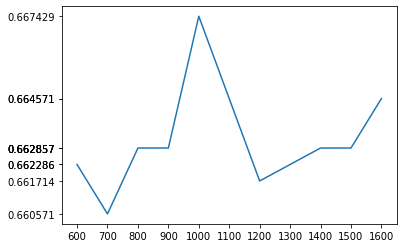

In [141]:
data = pd.DataFrame(scores_res).sort_values(by=0)

x,y = data[0], data[1]
plt.plot(x, y)
plt.xticks(x)
plt.yticks(y)

None

(850, 0.6611428571428571)
(950, 0.664)
(1050, 0.6645714285714286)
(1150, 0.664)


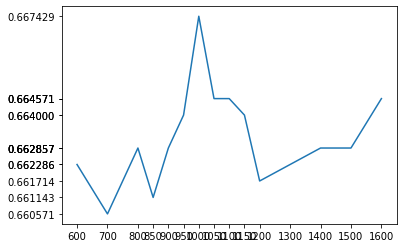

In [142]:
for n in [850, 950, 1050, 1150]:
    model = XGBClassifier(random_state=11, n_estimators=n, max_depth=6)
    model.fit(X_train_pre, y_train)
    
    score_res = model.score(X_test_pre, y_test)
        
    scores_res.append((n, score_res))
    print((n, score_res))
    
data = pd.DataFrame(scores_res).sort_values(by=0)

x,y = data[0], data[1]
plt.plot(x, y)
plt.xticks(x)
plt.yticks(y)

None

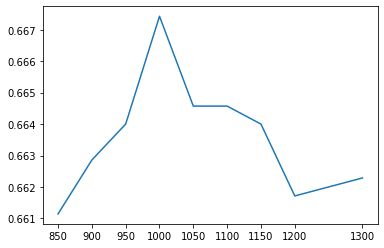

In [153]:
x,y = data[0], data[1]
plt.plot(x[3:-3], y[3:-3])
plt.xticks(x[3:-3])
None

# Conclustions on n_estimators
1000 in not good.
But, 1100 is reliable

In [154]:
model = XGBClassifier(random_state=11, n_estimators=1100, max_depth=6)

model.fit(X_train_pre, y_train)

model.score(X_test_pre, y_test)

# Score 0.664

0.6645714285714286

In [155]:
# complit

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
        self.block_time_start = 0
        
    def fit(self, x, y):
        self.block_time('fit', False)
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (50, 60)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

steps = [
    ('pre_processor', PreProcessor()),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=1100, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.664 (66.4%)

fit take: 0.02s
transform 15750
resize dim (50, 60)
..........
transform take: 282.s
transform 1750
resize dim (50, 60)
..........
transform take: 42.8s


0.6645714285714286

In [158]:
# self.resize_dim = (50, 50)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
        self.block_time_start = 0
        
    def fit(self, x, y):
        self.block_time('fit', False)
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (50, 50)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

steps = [
    ('pre_processor', PreProcessor()),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=1100, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.672

fit take: 0.01s
transform 15750
resize dim (50, 50)
..........
transform take: 296.s
transform 1750
resize dim (50, 50)
..........
transform take: 35.1s


0.672

In [159]:
# self.resize_dim = (50, 50)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (50, 50)):
        self.resize_dim = resize_dim
        self.block_time_start = 0
        
    def fit(self, x, y):
        self.block_time('fit', False)
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        #self.resize_dim = (width_median, height_median)
        
        #self.resize_dim = (50, 50)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

scores_res = []
for size_l in range(30, 120+1, 10):
    steps = [
        ('pre_processor', PreProcessor(resize_dim = (size_l, size_l))),
        ('xgmc', XGBClassifier(random_state=11, n_estimators=1100, max_depth=6))
    ]

    model = Pipeline(steps)

    model.fit(X_train, y_train)
    
    score_res = model.score(X_test, y_test)
        
    scores_res.append((size_l, score_res))
    print((size_l, score_res))
    
data = pd.DataFrame(scores_res).sort_values(by=0)
data


fit take: 0.02s
transform 15750
resize dim (30, 30)
..........
transform take: 120.s
transform 1750
resize dim (30, 30)
..........
transform take: 13.1s
(30, 0.668)
fit take: 0.01s
transform 15750
resize dim (40, 40)
..........
transform take: 204.s
transform 1750
resize dim (40, 40)
..........
transform take: 22.8s
(40, 0.6702857142857143)
fit take: 0.01s
transform 15750
resize dim (50, 50)
..........
transform take: 305.s
transform 1750
resize dim (50, 50)
..........
transform take: 39.1s
(50, 0.672)
fit take: 0.02s
transform 15750
resize dim (60, 60)
..........
transform take: 504.s
transform 1750
resize dim (60, 60)
..........
transform take: 51.4s
(60, 0.68)
fit take: 0.01s
transform 15750
resize dim (70, 70)
..........
transform take: 614.s
transform 1750
resize dim (70, 70)
..........
transform take: 67.6s
(70, 0.68)
fit take: 0.02s
transform 15750
resize dim (80, 80)
..........
transform take: 904.s
transform 1750
resize dim (80, 80)
..........
transform take: 86.0s
(80, 0.6868

,0,1
0,30,0.668000
1,40,0.670286
2,50,0.672000
3,60,0.680000
4,70,0.680000
5,80,0.686857
6,90,0.678286
7,100,0.680571
8,110,0.680000
9,120,0.672571


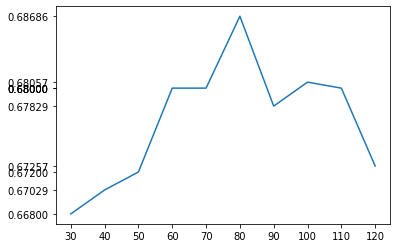

In [160]:
x,y = data[0], data[1]
plt.plot(x, y)
plt.xticks(x)
plt.yticks(y)

None

In [ ]:
# self.resize_dim = (80, 80)

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.resize_dim = (100, 100)
        self.block_time_start = 0
        
    def fit(self, x, y):
        self.block_time('fit', False)
        
        width_ls = []
        height_ls = []
                        
        for sample in X_train:
            width_ls.append(sample.shape[0])
            height_ls.append(sample.shape[1])

        width_median = int(pd.Series(width_ls).median())
        height_median = int(pd.Series(height_ls).median())
                
        self.resize_dim = (width_median, height_median)
        
        self.resize_dim = (80, 80)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

steps = [
    ('pre_processor', PreProcessor()),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=1100, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 

fit take: 0.01s
transform 15750
resize dim (80, 80)
..........
transform take: 555.s


In [17]:
# resize_dim as hyper paramter

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (80, 80), **kwargs):
        self.resize_dim = resize_dim
        
        self.block_time_start = 0
    
        self._param_names = ['resize_dim'] + list(kwargs.keys())
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    
    def fit(self, x, y):
        self.block_time('fit', False)
        
        if self.resize_dim == None:
            width_ls = []
            height_ls = []
                        
            for sample in X_train:
                width_ls.append(sample.shape[0])
                height_ls.append(sample.shape[1])

            width_median = int(pd.Series(width_ls).median())
            height_median = int(pd.Series(height_ls).median())
                
            self.resize_dim = (width_median, height_median)
                
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

N_ESTIMATORS = 100
        
steps = [
    ('pre_processor', PreProcessor(resize_dim=(28,28))),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=N_ESTIMATORS, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.631

fit take: 0.0s
transform 15750
resize dim (28, 28)
..........
transform take: 278.s
transform 1750
resize dim (28, 28)
..........
transform take: 23.9s


0.6314285714285715

In [20]:
# resize_dim as hyper paramter

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (80, 80), **kwargs):
        self.resize_dim = resize_dim
        
        self.block_time_start = 0
    
        self._param_names = ['resize_dim'] + list(kwargs.keys())
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    
    def fit(self, x, y):
        self.block_time('fit', False)
        
        if self.resize_dim == None:
            width_ls = []
            height_ls = []
                        
            for sample in X_train:
                width_ls.append(sample.shape[0])
                height_ls.append(sample.shape[1])

            width_median = int(pd.Series(width_ls).median())
            height_median = int(pd.Series(height_ls).median())
                
            self.resize_dim = (width_median, height_median)
                
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

N_ESTIMATORS = 100
        
steps = [
    ('pre_processor', PreProcessor(resize_dim=(28,28))),
    ('pce', PCA(28)),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=N_ESTIMATORS, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.631

fit take: 0.0s
transform 15750
resize dim (28, 28)
..........
transform take: 245.s
transform 1750
resize dim (28, 28)
..........
transform take: 21.4s


0.6205714285714286

In [25]:
# resize_dim as hyper paramter

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (80, 80), pca=PCA(), **kwargs):
        self.resize_dim = resize_dim
        self.pca = pca        
        
        self.block_time_start = 0
    
        self._param_names = ['resize_dim', 'pca'] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    
    def fit(self, x, y):
        self.block_time('fit', False)
        
        if self.resize_dim == None:
            width_ls = []
            height_ls = []
                        
            for sample in x:
                width_ls.append(sample.shape[0])
                height_ls.append(sample.shape[1])

            width_median = int(pd.Series(width_ls).median())
            height_median = int(pd.Series(height_ls).median())
                
            self.resize_dim = (width_median, height_median)
        
        self.pca.fit(x)
        
        self.block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        self.block_time('transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
            
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, resized_img)
            
            #as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            as_vaector = self.pca.transform(x)
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        self.block_time('transform', True)
        
        return X_df
    
    def block_time(self, block_name: str, is_ended: bool):
        if is_ended:
            t = time.time() - self.block_time_start
            print(block_name + ' take: ' + str(t)[:4] + 's')            
            
        self.block_time_start = time.time()

N_ESTIMATORS = 100

steps = [
    ('pre_processor', PreProcessor(resize_dim=(28,28), pca=PCA())),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=N_ESTIMATORS, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.631

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15750,) + inhomogeneous part.

In [32]:
block_time_start = 0
def block_time(block_name: str, is_ended: bool):
    global block_time_start
    if is_ended:
        t = time.time() - block_time_start
        print(block_name + ' take: ' + str(t)[:4] + 's')            
            
    block_time_start = time.time()

In [36]:
# seperate to two transformers

class ResizeImagesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (80, 80), **kwargs):
        self.resize_dim = resize_dim
            
        self._param_names = ['resize_dim'] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    def fit(self, x, y):        
        if self.resize_dim == None:
            width_ls = []
            height_ls = []
                        
            for sample in x:
                width_ls.append(sample.shape[0])
                height_ls.append(sample.shape[1])

            width_median = int(pd.Series(width_ls).median())
            height_median = int(pd.Series(height_ls).median())
                
            self.resize_dim = (width_median, height_median)
                        
        return self
    
    def transform(self, x, y = None):
        
        block_time('resize transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
                
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "") 
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            new_x[i] = resized_img
        print('')
        
        block_time('resize transform', True)
        
        return new_x

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, pca=PCA(), **kwargs):
        self.pca = pca        
            
        self._param_names = ['pca'] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    
    def fit(self, x, y):
        block_time('fit', False)
        
        #self.pca.fit(x)
        
        block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        block_time('transform', False)
        
        print("transform " + str(len(x)))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
                        
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, sample)
            
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            #as_vaector = self.pca.transform(x)
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
                
        block_time('transform', True)
        
        return X_df

N_ESTIMATORS = 100

steps = [
    ('resize', ResizeImagesTransformer(resize_dim=(28,28))),
    ('pre_processor', PreProcessor(pca=PCA())),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=N_ESTIMATORS, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.631

transform 15750
resize dim (28, 28)
..........
resize transform take: 76.5s
fit take: 0.0s
transform 15750
..........
transform take: 119.s
transform 1750
resize dim (28, 28)
..........
resize transform take: 7.74s
transform 1750
..........
transform take: 10.2s


0.6314285714285715

In [ ]:
# using PCA

class ResizeImagesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, resize_dim = (80, 80), **kwargs):
        self.resize_dim = resize_dim
            
        self._param_names = ['resize_dim'] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    def fit(self, x, y):        
        if self.resize_dim == None:
            width_ls = []
            height_ls = []
                        
            for sample in x:
                width_ls.append(sample.shape[0])
                height_ls.append(sample.shape[1])

            width_median = int(pd.Series(width_ls).median())
            height_median = int(pd.Series(height_ls).median())
                
            self.resize_dim = (width_median, height_median)
                        
        return self
    
    def transform(self, x, y = None):
        
        block_time('resize transform', False)
        
        print("transform " + str(len(x)))
        print("resize dim " + str(self.resize_dim))
        
        new_x = x.copy()
                
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "") 
            resized_img = cv2.resize(sample, self.resize_dim, interpolation = cv2.INTER_AREA)
            
            new_x[i] = resized_img
        print('')
        
        block_time('resize transform', True)
        
        return new_x

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, pca=PCA(), **kwargs):
        self.pca = pca        
            
        self._param_names = ['pca'] + list(kwargs.keys())
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def get_params(self, deep=True):
        return { param: getattr(self, param) for param in self._param_names}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
    
    def fit(self, x, y):
        block_time('fit', False)
        
        #self.pca.fit(x)
        
        block_time('fit', True)
        
        return self
    
    def transform(self, x, y = None):
        
        block_time('transform', False)
        
        print("transform " + str(len(x)))
        
        new_x = x.copy()
        
        pes = int(len(new_x) / 10)
        
        for i, sample in enumerate(new_x):
            if i % pes == 0:
                print('.', end = "")
                        
            grayscaled_img = np.apply_along_axis(lambda x: (x.sum() / 3), 2, sample)
                                    
            as_vaector = grayscaled_img.reshape((grayscaled_img.shape[0] * grayscaled_img.shape[1]))
            
            new_x[i] = as_vaector
        
        print('')
        
        X_df = pd.DataFrame(new_x)
        
        X_df = self.pca.fit_transform(x)
                
        block_time('transform', True)
        
        return X_df

N_ESTIMATORS = 100

steps = [
    ('resize', ResizeImagesTransformer(resize_dim=(28,28))),
    ('pre_processor', PreProcessor(pca=PCA())),
    ('xgmc', XGBClassifier(random_state=11, n_estimators=N_ESTIMATORS, max_depth=6))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

model.score(X_test, y_test)

# Score 0.631

transform 15750
resize dim (28, 28)
..........